In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import random
import numpy as np
import matplotlib.pyplot as plt


from keras import layers, Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences


import pandas as pd
from scipy.signal import butter, lfilter
from scipy import stats
from scipy.io import loadmat

#import heartpy as hp

from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


import seaborn as sns


import math
import random
import zipfile  
import io
from PIL import Image

In [2]:
SEED = 4224
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [3]:
from google.colab import drive
drive.mount('/content/drive')
cwd = '/content/drive/My Drive/FinalAssignment'
os.chdir(cwd)
dataset_folder = os.path.join(cwd,'training_set_dir')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def load_data(sample_prefix, input_dir):    # everything is returned as a numpy array which is easier to manipulate
  label_filepath = os.path.join(input_dir, sample_prefix + '_ann.mat')
  peak_filepath = os.path.join(input_dir, sample_prefix + '_rpk.mat')
  signal_filepath = os.path.join(input_dir, sample_prefix + '.mat')
  if os.path.isfile(label_filepath):
    mat_file = loadmat(label_filepath)
    label = np.asarray(mat_file['labels'])
  if os.path.isfile(peak_filepath):
    mat_file = loadmat(peak_filepath)
    peak = np.asarray(mat_file['rpeaks'])
  if os.path.isfile(signal_filepath):
    mat_file = loadmat(signal_filepath)
    signal = np.asarray(mat_file['ecg'] )

  return label, peak, signal

  
labels = list()             # labels 
ids = list()                # Id of samples 
rpeaks = list()             # detected peaks of the signal 
ecg_signals = list()        # .mat ecg signal 
frequencies = list()        # sample frequency of the ecg signal 


for f in os.listdir(dataset_folder):
  if f.lower().endswith('.mat'):
    id = f[:4]
    if id not in ids:
      ids.append(id)
      sample_prefix = f[:8]
      label, peak, signal = load_data(sample_prefix, dataset_folder)
      labels.append(label)
      rpeaks.append(peak)
      ecg_signals.append(signal)
      frequencies.append(int(sample_prefix[5:]))

print(len(rpeaks))
print(len(rpeaks[0]))

105
2851


In [5]:
cols = ["sigId","ecg_lead_1","ecg_lead_2","peaks","frequencies","labels"]

# ecg signals is 105 rows [,,,,,]

first_lead_signals = []
second_lead_signals = []

for signal in ecg_signals:
    first_lead_signals.append(signal[:,0].tolist())    # converting the array to list as list of array is deprecated 
    second_lead_signals.append(signal[:,1].tolist())

df = pd.DataFrame(data =[ids,first_lead_signals,second_lead_signals,rpeaks,frequencies,labels]).T
df.columns = cols
df

,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S001,"[0.0, 0.04, 0.03, 0.0, 0.03, 0.09, 0.18, 0.14,...","[0.08, 0.07, 0.1, 0.06, 0.06, 0.03, 0.1, 0.21,...","[[29], [110], [191], [272], [353], [433], [514...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
1,S002,"[-0.035, -0.045, -0.025, -0.035, -0.045, -0.05...","[-0.095, -0.105, -0.095, -0.095, -0.115, -0.09...","[[48], [153], [243], [352], [440], [547], [636...",128,"[N, N, N, N, S, N, S, N, S, N, S, N, S, N, S, ..."
2,S003,"[-0.56, -0.56, -0.55, -0.47, -0.53, -0.47, -0....","[0.43, 0.56, 0.6, 0.41, 0.54, 0.48, 0.56, 0.46...","[[91], [209], [326], [394], [537], [653], [745...",128,"[N, N, N, S, N, N, S, N, N, S, N, N, N, N, N, ..."
3,S004,"[-0.46, -0.49, -0.52, -0.58, -0.62, -0.69, -0....","[0.56, 0.61, 0.66, 0.66, 0.63, 0.66, 0.59, 0.5...","[[98], [223], [349], [474], [599], [726], [853...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S005,"[-0.27, -0.17, -0.13, -0.23, -0.18, -0.23, -0....","[-0.02, -0.04, -0.01, -0.01, -0.02, -0.06, 0.0...","[[27], [127], [225], [324], [423], [523], [623...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
...,...,...,...,...,...,...
100,S114,"[-0.22, -0.225, -0.23, -0.22, -0.185, -0.155, ...","[-0.86, -0.905, -0.94, -0.975, -1.0, -1.025, -...","[[155], [383], [611], [835], [1053], [1275], [...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
101,S115,"[0.385, 0.35, 0.31, 0.285, 0.265, 0.25, 0.225,...","[0.515, 0.45, 0.38, 0.33, 0.3, 0.28, 0.25, 0.2...","[[215], [437], [667], [823], [1119], [1349], [...",250,"[N, N, N, V, N, N, N, V, N, N, N, N, N, N, N, ..."
102,S116,"[-0.12, -0.12, -0.12, -0.125, -0.12, -0.115, -...","[-0.1, -0.105, -0.11, -0.125, -0.135, -0.13, -...","[[255], [535], [817], [1093], [1377], [1657], ...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
103,S117,"[-0.045, -0.045, -0.045, -0.045, -0.045, -0.04...","[0.175, 0.185, 0.18, 0.175, 0.175, 0.175, 0.17...","[[19], [295], [575], [863], [1151], [1435], [1...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."


In [6]:
# dataset needs to be created because we need to classify beats and not the entire signal 

classes = np.array(["N","S","V"])

def convert_to_one_hot(label):
    return np.array(classes == label,dtype=np.float32)


dataset = dict()
length = 170    # length of each signal, centered at the considered peak
counter = 0


for l,id in enumerate(ids):
    print(f"{l}/{len(ids)}",end='\r')
    for i,peak in enumerate(rpeaks[l]):
        
        dataset[id+"_"+str(i)] = {}
        dataset[id+"_"+str(i)]["first_lead"] = list()
        dataset[id+"_"+str(i)]["second_lead"] = list()

        for s in range(int(peak-length/2),int(peak+length/2)):

            if(s < 0 or s >= len(first_lead_signals[l])):   # padding with 0
                dataset[id+"_"+str(i)]["first_lead"].append(0.) 
                dataset[id+"_"+str(i)]["second_lead"].append(0.) 
            else:
                dataset[id+"_"+str(i)]["first_lead"].append(first_lead_signals[l][s])
                dataset[id+"_"+str(i)]["second_lead"].append(first_lead_signals[l][s])

        dataset[id+"_"+str(i)]["stringLabel"] = labels[l][i]
        dataset[id+"_"+str(i)]["label"] = convert_to_one_hot(labels[l][i])
    
print("complete")

dataset_df = pd.DataFrame.from_dict(dataset,orient="index") # create the dataframe from dictionary 

dataset_df

# dataset is complete (no NaN values)

complete


,first_lead,second_lead,stringLabel,label
S001_0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",N,"[1.0, 0.0, 0.0]"
S001_1,"[0.825, 1.46, 2.095, 1.455, 0.815, 0.175, -0.4...","[0.825, 1.46, 2.095, 1.455, 0.815, 0.175, -0.4...",N,"[1.0, 0.0, 0.0]"
S001_2,"[1.045, 1.68, 2.05, 1.41, 0.77, 0.13, -0.39, -...","[1.045, 1.68, 2.05, 1.41, 0.77, 0.13, -0.39, -...",N,"[1.0, 0.0, 0.0]"
S001_3,"[1.125, 1.76, 1.94, 1.3, 0.66, 0.02, -0.4, -0....","[1.125, 1.76, 1.94, 1.3, 0.66, 0.02, -0.4, -0....",N,"[1.0, 0.0, 0.0]"
S001_4,"[1.25, 1.885, 1.48, 0.84, 0.2, -0.44, -0.38, -...","[1.25, 1.885, 1.48, 0.84, 0.2, -0.44, -0.38, -...",N,"[1.0, 0.0, 0.0]"
...,...,...,...,...
S118_2447,"[0.015, 0.01, 0.01, 0.005, 0.0, 0.0, 0.005, 0....","[0.015, 0.01, 0.01, 0.005, 0.0, 0.0, 0.005, 0....",N,"[1.0, 0.0, 0.0]"
S118_2448,"[-0.02, -0.025, -0.025, -0.025, -0.025, -0.025...","[-0.02, -0.025, -0.025, -0.025, -0.025, -0.025...",N,"[1.0, 0.0, 0.0]"
S118_2449,"[-0.04, -0.04, -0.045, -0.05, -0.055, -0.055, ...","[-0.04, -0.04, -0.045, -0.05, -0.055, -0.055, ...",N,"[1.0, 0.0, 0.0]"
S118_2450,"[-0.005, -0.005, -0.01, -0.015, -0.02, -0.03, ...","[-0.005, -0.005, -0.01, -0.015, -0.02, -0.03, ...",N,"[1.0, 0.0, 0.0]"


In [7]:
import random

validation_percentage = 0.2
# N beats samples: 226932
# S beats samples: 9609
# V beats samples: 7795

# to balance classes we may want to drop at least 216k normal beats in input

to_drop = 0
SEED = 1234
random.seed(SEED)

ids_to_drop = list()

ids = dataset_df.index[dataset_df['stringLabel'] == 'N'].tolist() #ids where label is = 'N'
random.shuffle(ids)
ids_to_drop = ids[:to_drop]

balanced_df = dataset_df.drop(ids_to_drop)
balanced_df

,first_lead,second_lead,stringLabel,label
S001_0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",N,"[1.0, 0.0, 0.0]"
S001_1,"[0.825, 1.46, 2.095, 1.455, 0.815, 0.175, -0.4...","[0.825, 1.46, 2.095, 1.455, 0.815, 0.175, -0.4...",N,"[1.0, 0.0, 0.0]"
S001_2,"[1.045, 1.68, 2.05, 1.41, 0.77, 0.13, -0.39, -...","[1.045, 1.68, 2.05, 1.41, 0.77, 0.13, -0.39, -...",N,"[1.0, 0.0, 0.0]"
S001_3,"[1.125, 1.76, 1.94, 1.3, 0.66, 0.02, -0.4, -0....","[1.125, 1.76, 1.94, 1.3, 0.66, 0.02, -0.4, -0....",N,"[1.0, 0.0, 0.0]"
S001_4,"[1.25, 1.885, 1.48, 0.84, 0.2, -0.44, -0.38, -...","[1.25, 1.885, 1.48, 0.84, 0.2, -0.44, -0.38, -...",N,"[1.0, 0.0, 0.0]"
...,...,...,...,...
S118_2447,"[0.015, 0.01, 0.01, 0.005, 0.0, 0.0, 0.005, 0....","[0.015, 0.01, 0.01, 0.005, 0.0, 0.0, 0.005, 0....",N,"[1.0, 0.0, 0.0]"
S118_2448,"[-0.02, -0.025, -0.025, -0.025, -0.025, -0.025...","[-0.02, -0.025, -0.025, -0.025, -0.025, -0.025...",N,"[1.0, 0.0, 0.0]"
S118_2449,"[-0.04, -0.04, -0.045, -0.05, -0.055, -0.055, ...","[-0.04, -0.04, -0.045, -0.05, -0.055, -0.055, ...",N,"[1.0, 0.0, 0.0]"
S118_2450,"[-0.005, -0.005, -0.01, -0.015, -0.02, -0.03, ...","[-0.005, -0.005, -0.01, -0.015, -0.02, -0.03, ...",N,"[1.0, 0.0, 0.0]"


N: 226932
V: 7795
S: 9609


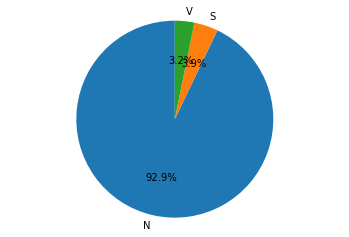

In [8]:
ids_n = balanced_df.index[balanced_df['stringLabel'] == 'N'].tolist() 
ids_v = balanced_df.index[balanced_df['stringLabel'] == 'V'].tolist() 
ids_s = balanced_df.index[balanced_df['stringLabel'] == 'S'].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_v)}")
print(f"S: {len(ids_s)}")

classes = ["N","S","V"]
counts = [len(ids_n),len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

# Training set

train_df, validation_df = train_test_split(balanced_df, test_size=validation_percentage)


x_train_ = train_df[['first_lead','second_lead']].values

x_train = list()
for k in x_train_:
    x_train.append(np.asarray(k[0]+k[1]).astype(np.float32))
x_train = np.asarray(x_train).astype(np.float32)

y_train = train_df['label'].values.tolist()
y_train = np.asarray(y_train).astype(np.float32)

# Validation set

x_valid_ = validation_df[['first_lead','second_lead']].values

x_valid = list()
for k in x_valid_:
    x_valid.append(np.asarray(k[0]+k[1]).astype(np.float32))
x_valid = np.asarray(x_valid).astype(np.float32)

y_valid = validation_df['label'].values.tolist()
y_valid = np.asarray(y_valid).astype(np.float32)

print(f"samples available for training: {len(x_train)}")
print(f"samples available for validation: {len(x_valid)}")

samples available for training: 195468
samples available for validation: 48868


N: 181559
V: 6220
S: 7689


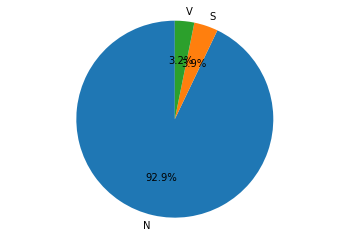

In [10]:
# count classes for training

ids_n = train_df.index[train_df['stringLabel'] == 'N'].tolist() 
ids_v = train_df.index[train_df['stringLabel'] == 'V'].tolist() 
ids_s = train_df.index[train_df['stringLabel'] == 'S'].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_v)}")
print(f"S: {len(ids_s)}")

classes = ["N","S","V"]
counts = [len(ids_n),len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

N: 45373
V: 1575
S: 1920


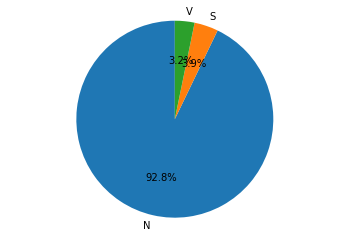

In [11]:
# count classes for validation

ids_n = validation_df.index[validation_df['stringLabel'] == 'N'].tolist() 
ids_v = validation_df.index[validation_df['stringLabel'] == 'V'].tolist() 
ids_s = validation_df.index[validation_df['stringLabel'] == 'S'].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_v)}")
print(f"S: {len(ids_s)}")

classes = ["N","S","V"]
counts = [len(ids_n),len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

# ML Models

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
  """
    :param ndarray y_true: contains the ground truth labels in the shape (n_samples,)
    :param ndarray y_pred: contains the predicted labels in the shape (n_samples,)
  """
  con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

### SVM

In [33]:
def conversion(vec):
  res = np.zeros(len(vec))
  for i in range(len(vec)):
    if vec[i] == 'S':
      res[i] = 1
    elif vec[i] == 'V':
      res[i] = 2
  return res

def plot_confusion_matrix(y_true, y_pred):
  """
    :param ndarray y_true: contains the ground truth labels in the shape (n_samples,)
    :param ndarray y_pred: contains the predicted labels in the shape (n_samples,)
  """
  

  con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

def TestSVM(train_features, train_labels, test_features, test_labels, clf):
  clf.fit(train_features, train_labels)

  # Predit test labels
  test_predicted = clf.predict(test_features)
  
  plot_confusion_matrix(conversion(test_labels), conversion(test_predicted))
                        
  # Display classification results
  print(classification_report(test_labels, test_predicted, target_names=['N', 'S', 'V']))

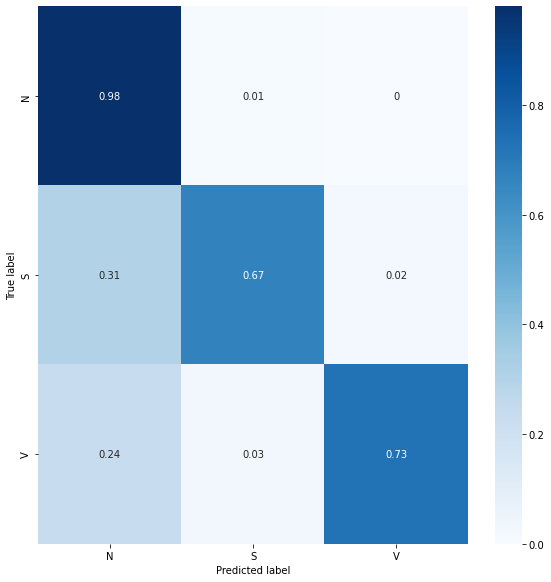

              precision    recall  f1-score   support

           N       0.98      0.98      0.98      9307
           S       0.65      0.67      0.66       407
           V       0.90      0.73      0.81       286

    accuracy                           0.96     10000
   macro avg       0.84      0.79      0.82     10000
weighted avg       0.96      0.96      0.96     10000



In [13]:
from sklearn import svm
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

weights = {'N': counts[0], 'S': counts[1], 'V': counts[2]}

clf = svm.SVC(C=1.0,
              kernel='rbf', # linear ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
              degree=6,
              gamma='scale',
              coef0=0.0, 
              shrinking=True,
              probability=False,
              tol=0.001,
              cache_size=200, 
              class_weight=weights,
              verbose=False,
              max_iter=- 1,
              decision_function_shape='ovr',
              break_ties=False,
              random_state=42)

TestSVM(x_train[:20000], train_df.stringLabel[:20000], x_valid[:10000], validation_df.stringLabel[:10000], clf)

### XGBoost

XGBoost with logistic objective

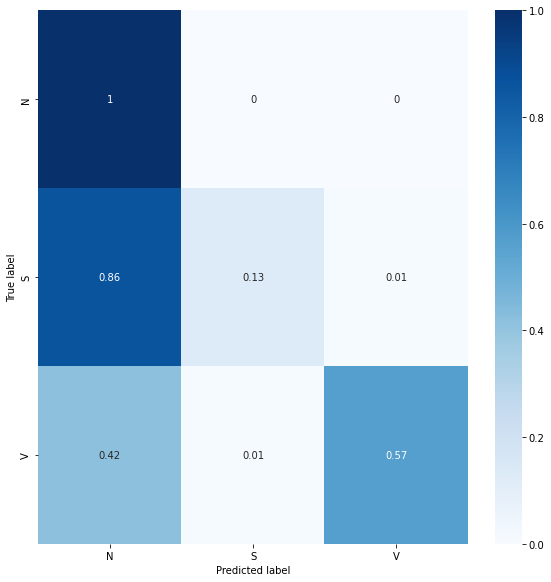

              precision    recall  f1-score   support

           N       0.95      1.00      0.97      9307
           S       0.89      0.13      0.23       407
           V       0.96      0.57      0.72       286

    accuracy                           0.95     10000
   macro avg       0.93      0.57      0.64     10000
weighted avg       0.95      0.95      0.94     10000



In [16]:
import xgboost as xgb
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score

# create XGBoost instance with default hyper-parameters
xgb_estimator = xgb.XGBClassifier(objective='binary:logistic')
#xgb_estimator = xgb.XGBClassifier(objective='binary:logitraw')


# create MultiOutputClassifier instance with XGBoost model inside
multilabel_model = MultiOutputClassifier(xgb_estimator)

# fit the model
multilabel_model.fit(x_train[:50000], y_train[:50000])

#test_predicted = multilabel_model.predict(x_valid)
test_predicted = multilabel_model.predict(x_valid[:10000])

y_pred=np.argmax(test_predicted,axis=1)
#y_val_classes=np.argmax(y_valid, axis=1)
y_val_classes=np.argmax(y_valid[:10000], axis=1)

plot_confusion_matrix(y_val_classes, y_pred)
                        
# Display classification results
print(classification_report(y_val_classes, y_pred, target_names=['N', 'S', 'V']))

XGBoost with softmax objective

[0]	train-merror:0.26567	val-merror:0.356593
[1]	train-merror:0.27069	val-merror:0.352378
[2]	train-merror:0.26819	val-merror:0.351437
[3]	train-merror:0.26784	val-merror:0.351334
[4]	train-merror:0.26657	val-merror:0.35115
[5]	train-merror:0.26748	val-merror:0.348899
[6]	train-merror:0.26843	val-merror:0.346566
[7]	train-merror:0.2697	val-merror:0.34542
[8]	train-merror:0.27067	val-merror:0.344049
[9]	train-merror:0.27044	val-merror:0.343906
[10]	train-merror:0.27287	val-merror:0.342658
[11]	train-merror:0.27058	val-merror:0.343231
[12]	train-merror:0.2718	val-merror:0.342433
[13]	train-merror:0.26994	val-merror:0.34274
[14]	train-merror:0.26797	val-merror:0.342719


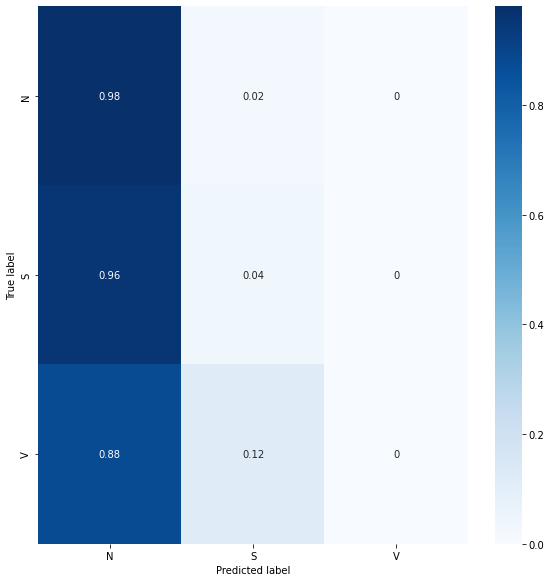

              precision    recall  f1-score   support

           N       0.93      0.98      0.95     45373
           S       0.06      0.04      0.05      1920
           V       0.00      0.00      0.00      1575

    accuracy                           0.91     48868
   macro avg       0.33      0.34      0.33     48868
weighted avg       0.87      0.91      0.89     48868



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
import xgboost as xgb

# Load data
xg_train = xgb.DMatrix(x_train[:100000], label=y_train[:100000])
xg_test = xgb.DMatrix(x_valid[:50000], label=y_valid[:50000])

# Setting parameters
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.01
param['gamma'] = 0.05
param['max_depth'] = 30
param['silent'] = 1
param['nthread'] = 5
param['num_class'] = 3
#param['eval_metric'] = ['auc', 'ams@0'] to set more metrics

watchlist = [(xg_train, 'train'), (xg_test, 'val')]
num_round = 15
bst = xgb.train(param, xg_train, num_round, watchlist)
# get prediction
pred = bst.predict(xg_test)

#y_val_classes=np.argmax(y_valid, axis=1)
y_val_classes=np.argmax(y_valid[:50000], axis=1)

plot_confusion_matrix(y_val_classes, pred)
                        
# Display classification results
print(classification_report(y_val_classes, pred, target_names=['N', 'S', 'V']))


### Multilabel k Nearest Neighbour

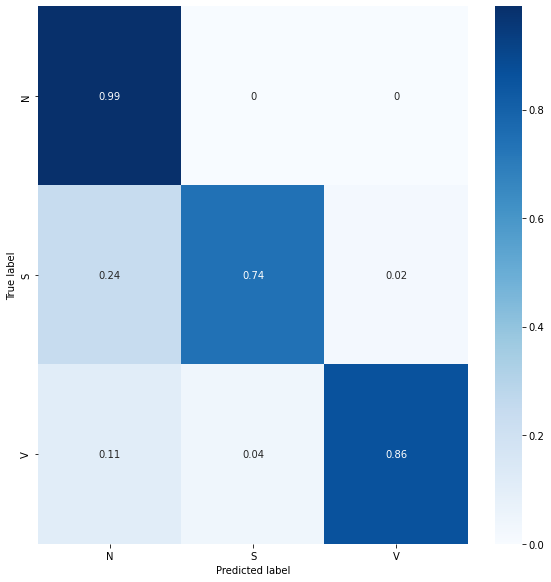

              precision    recall  f1-score   support

           N       0.99      0.99      0.99     45373
           S       0.84      0.74      0.79      1920
           V       0.95      0.86      0.90      1575

    accuracy                           0.98     48868
   macro avg       0.93      0.86      0.89     48868
weighted avg       0.98      0.98      0.98     48868



In [14]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==0.24.1

!pip install scikit-multilearn


from skmultilearn.adapt import MLkNN

classifier = MLkNN(k=3)

# train
classifier.fit(x_train[:100000], y_train[:100000])

# predict
predictions = classifier.predict(x_valid[:50000])

pred = predictions.toarray()
y_pred=np.argmax(pred,axis=1)
y_val_classes=np.argmax(y_valid[:50000], axis=1)

plot_confusion_matrix(y_val_classes, y_pred)
                        
# Display classification results
print(classification_report(y_val_classes, y_pred, target_names=['N', 'S', 'V']))

Other implementation

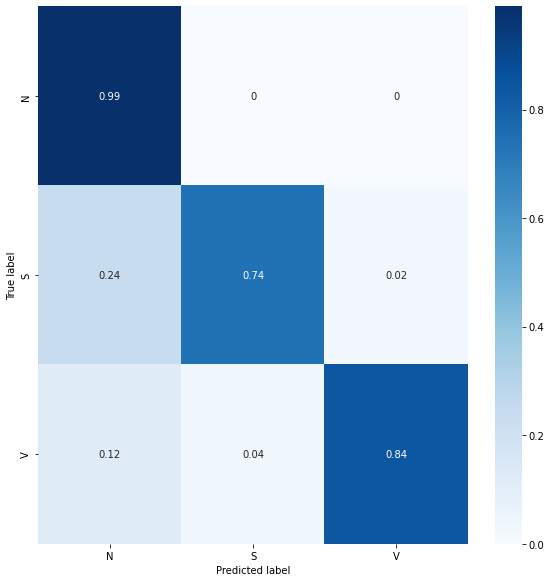

              precision    recall  f1-score   support

           N       0.99      0.99      0.99     45373
           S       0.84      0.74      0.79      1920
           V       0.95      0.84      0.89      1575

    accuracy                           0.98     48868
   macro avg       0.93      0.86      0.89     48868
weighted avg       0.98      0.98      0.98     48868



In [26]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3, weights='distance') # weights{‘uniform’, ‘distance’} or callable, default=’uniform’

neigh.fit(x_train[:100000], y_train[:100000])

# predict
predictions = neigh.predict(x_valid[:50000])
y_pred=np.argmax(predictions,axis=1)
y_val_classes=np.argmax(y_valid[:50000], axis=1)

plot_confusion_matrix(y_val_classes, y_pred)
                        
# Display classification results
print(classification_report(y_val_classes, y_pred, target_names=['N', 'S', 'V']))

### Multinomial Logistic Regression

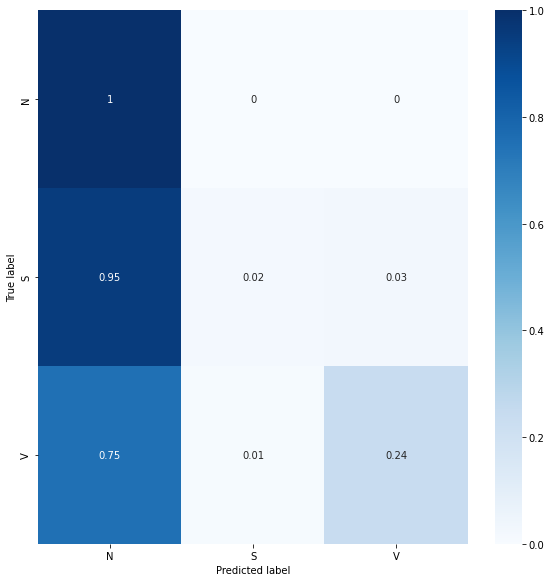

              precision    recall  f1-score   support

           N       0.94      1.00      0.97     45373
           S       0.46      0.02      0.04      1920
           V       0.73      0.24      0.36      1575

    accuracy                           0.93     48868
   macro avg       0.71      0.42      0.46     48868
weighted avg       0.91      0.93      0.91     48868



In [17]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

y_train_classes=np.argmax(y_train[:100000], axis=1)
# fit the model on the whole dataset
model.fit(x_train[:100000], y_train_classes)

# predict the class label
pred = model.predict(x_valid[:50000])

#y_val_classes=np.argmax(y_valid, axis=1)
y_val_classes=np.argmax(y_valid[:50000], axis=1)

plot_confusion_matrix(y_val_classes, pred)
                        
# Display classification results
print(classification_report(y_val_classes, pred, target_names=['N', 'S', 'V']))

# ML Models with balanced dataset

In [27]:
import random

validation_percentage = 0.2
# N beats samples: 226932
# S beats samples: 9609
# V beats samples: 7795

# to balance classes we may want to drop at least 216k normal beats in input

to_drop = 216000
SEED = 1234
random.seed(SEED)

ids_to_drop = list()

ids = dataset_df.index[dataset_df['stringLabel'] == 'N'].tolist() #ids where label is = 'N'
random.shuffle(ids)
ids_to_drop = ids[:to_drop]

balanced_df = dataset_df.drop(ids_to_drop)
balanced_df

,first_lead,second_lead,stringLabel,label
S001_8,"[1.07, 1.705, 1.72, 1.08, 0.44, -0.2, -0.42, -...","[1.07, 1.705, 1.72, 1.08, 0.44, -0.2, -0.42, -...",N,"[1.0, 0.0, 0.0]"
S001_17,"[0.04, 0.06, 0.05, 0.04, 0.04, -0.01, 0.0, 0.0...","[0.04, 0.06, 0.05, 0.04, 0.04, -0.01, 0.0, 0.0...",V,"[0.0, 0.0, 1.0]"
S001_19,"[-0.02, -0.05, -0.05, -0.06, -0.08, -0.08, -0....","[-0.02, -0.05, -0.05, -0.06, -0.08, -0.08, -0....",V,"[0.0, 0.0, 1.0]"
S001_21,"[0.0, -0.01, -0.03, -0.05, -0.05, -0.06, -0.01...","[0.0, -0.01, -0.03, -0.05, -0.05, -0.06, -0.01...",V,"[0.0, 0.0, 1.0]"
S001_37,"[0.29, 0.925, 1.56, 2.11, 1.47, 0.83, 0.19, -0...","[0.29, 0.925, 1.56, 2.11, 1.47, 0.83, 0.19, -0...",N,"[1.0, 0.0, 0.0]"
...,...,...,...,...
S118_2343,"[0.01, 0.0, -0.005, -0.02, -0.035, -0.035, -0....","[0.01, 0.0, -0.005, -0.02, -0.035, -0.035, -0....",N,"[1.0, 0.0, 0.0]"
S118_2394,"[0.01, 0.005, 0.005, 0.005, 0.01, 0.01, 0.0, -...","[0.01, 0.005, 0.005, 0.005, 0.01, 0.01, 0.0, -...",N,"[1.0, 0.0, 0.0]"
S118_2396,"[0.0, 0.0, 0.015, 0.015, -0.005, 0.0, 0.02, 0....","[0.0, 0.0, 0.015, 0.015, -0.005, 0.0, 0.02, 0....",N,"[1.0, 0.0, 0.0]"
S118_2440,"[0.015, 0.015, 0.02, 0.03, 0.035, 0.035, 0.025...","[0.015, 0.015, 0.02, 0.03, 0.035, 0.035, 0.025...",N,"[1.0, 0.0, 0.0]"


N: 10932
V: 7795
S: 9609


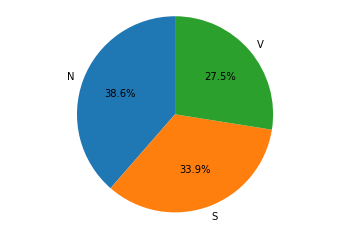

In [28]:
ids_n = balanced_df.index[balanced_df['stringLabel'] == 'N'].tolist() 
ids_v = balanced_df.index[balanced_df['stringLabel'] == 'V'].tolist() 
ids_s = balanced_df.index[balanced_df['stringLabel'] == 'S'].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_v)}")
print(f"S: {len(ids_s)}")

classes = ["N","S","V"]
counts = [len(ids_n),len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

In [29]:
from sklearn.model_selection import train_test_split

# Training set

train_df, validation_df = train_test_split(balanced_df, test_size=validation_percentage)


x_train_ = train_df[['first_lead','second_lead']].values

x_train = list()
for k in x_train_:
    x_train.append(np.asarray(k[0]+k[1]).astype(np.float32))
x_train = np.asarray(x_train).astype(np.float32)

y_train = train_df['label'].values.tolist()
y_train = np.asarray(y_train).astype(np.float32)

# Validation set

x_valid_ = validation_df[['first_lead','second_lead']].values

x_valid = list()
for k in x_valid_:
    x_valid.append(np.asarray(k[0]+k[1]).astype(np.float32))
x_valid = np.asarray(x_valid).astype(np.float32)

y_valid = validation_df['label'].values.tolist()
y_valid = np.asarray(y_valid).astype(np.float32)

print(f"samples available for training: {len(x_train)}")
print(f"samples available for validation: {len(x_valid)}")

samples available for training: 22668
samples available for validation: 5668


N: 8784
V: 6185
S: 7699


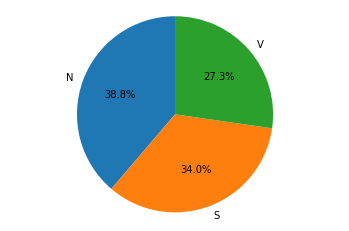

In [30]:
# count classes for training

ids_n = train_df.index[train_df['stringLabel'] == 'N'].tolist() 
ids_v = train_df.index[train_df['stringLabel'] == 'V'].tolist() 
ids_s = train_df.index[train_df['stringLabel'] == 'S'].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_v)}")
print(f"S: {len(ids_s)}")

classes = ["N","S","V"]
counts = [len(ids_n),len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

N: 2148
V: 1610
S: 1910


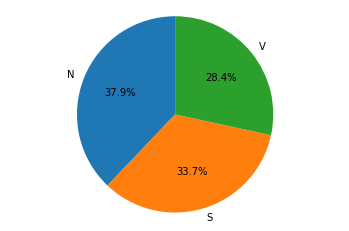

In [31]:
# count classes for validation

ids_n = validation_df.index[validation_df['stringLabel'] == 'N'].tolist() 
ids_v = validation_df.index[validation_df['stringLabel'] == 'V'].tolist() 
ids_s = validation_df.index[validation_df['stringLabel'] == 'S'].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_v)}")
print(f"S: {len(ids_s)}")

classes = ["N","S","V"]
counts = [len(ids_n),len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

### SVM

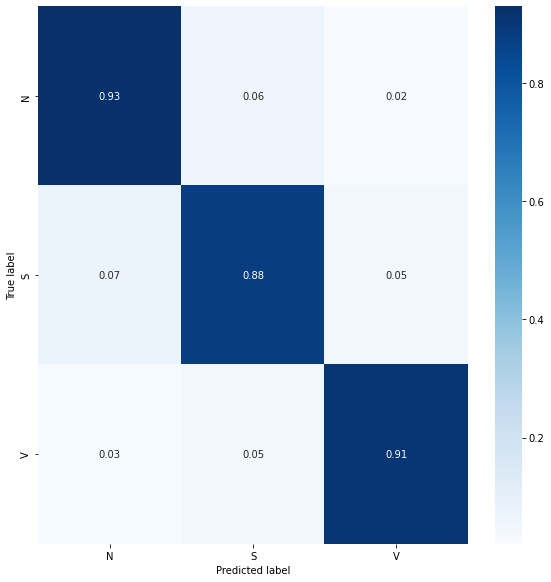

              precision    recall  f1-score   support

           N       0.91      0.93      0.92      2148
           S       0.89      0.88      0.89      1910
           V       0.92      0.91      0.92      1610

    accuracy                           0.91      5668
   macro avg       0.91      0.91      0.91      5668
weighted avg       0.91      0.91      0.91      5668



In [34]:
from sklearn import svm
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

weights = {'N': counts[0], 'S': counts[1], 'V': counts[2]}

clf = svm.SVC(C=1.0,
              kernel='rbf', # linear ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
              degree=6,
              gamma='scale',
              coef0=0.0, 
              shrinking=True,
              probability=False,
              tol=0.001,
              cache_size=200, 
              class_weight=weights,
              verbose=False,
              max_iter=- 1,
              decision_function_shape='ovr',
              break_ties=False,
              random_state=42)

TestSVM(x_train, train_df.stringLabel, x_valid, validation_df.stringLabel, clf)

### XGBoost

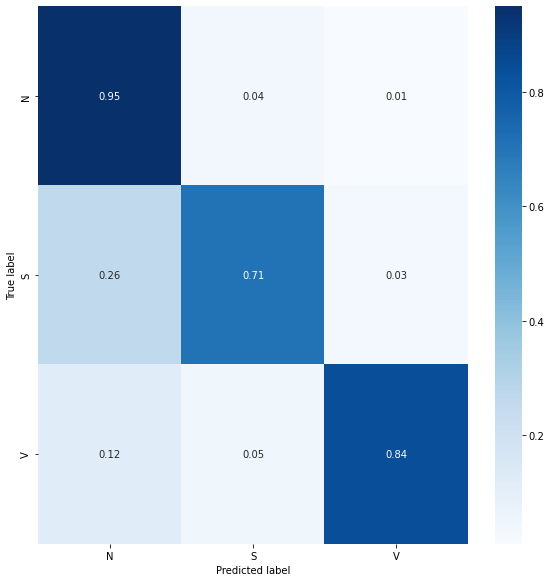

              precision    recall  f1-score   support

           N       0.75      0.95      0.84      2148
           S       0.90      0.71      0.79      1910
           V       0.95      0.84      0.89      1610

    accuracy                           0.84      5668
   macro avg       0.87      0.83      0.84      5668
weighted avg       0.86      0.84      0.84      5668



In [35]:
import xgboost as xgb
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score

# create XGBoost instance with default hyper-parameters
xgb_estimator = xgb.XGBClassifier(objective='binary:logistic')
#xgb_estimator = xgb.XGBClassifier(objective='binary:logitraw')


# create MultiOutputClassifier instance with XGBoost model inside
multilabel_model = MultiOutputClassifier(xgb_estimator)

# fit the model
multilabel_model.fit(x_train, y_train)

#test_predicted = multilabel_model.predict(x_valid)
test_predicted = multilabel_model.predict(x_valid)

y_pred=np.argmax(test_predicted,axis=1)
#y_val_classes=np.argmax(y_valid, axis=1)
y_val_classes=np.argmax(y_valid, axis=1)

plot_confusion_matrix(y_val_classes, y_pred)
                        
# Display classification results
print(classification_report(y_val_classes, y_pred, target_names=['N', 'S', 'V']))

### Multilabel k Nearest Neighbour

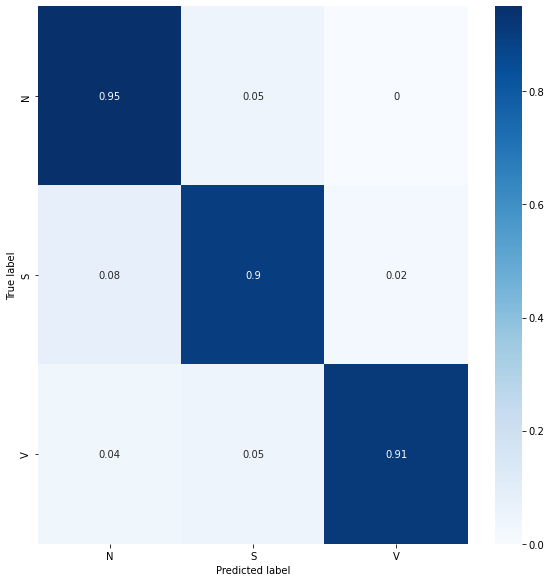

              precision    recall  f1-score   support

           N       0.90      0.95      0.93      2148
           S       0.91      0.90      0.90      1910
           V       0.97      0.91      0.94      1610

    accuracy                           0.92      5668
   macro avg       0.93      0.92      0.92      5668
weighted avg       0.92      0.92      0.92      5668



In [37]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3, weights='uniform') # weights{‘uniform’, ‘distance’} or callable, default=’uniform’

neigh.fit(x_train[:100000], y_train[:100000])

# predict
predictions = neigh.predict(x_valid[:50000])
y_pred=np.argmax(predictions,axis=1)
y_val_classes=np.argmax(y_valid[:50000], axis=1)

plot_confusion_matrix(y_val_classes, y_pred)
                        
# Display classification results
print(classification_report(y_val_classes, y_pred, target_names=['N', 'S', 'V']))

### Multinomial Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


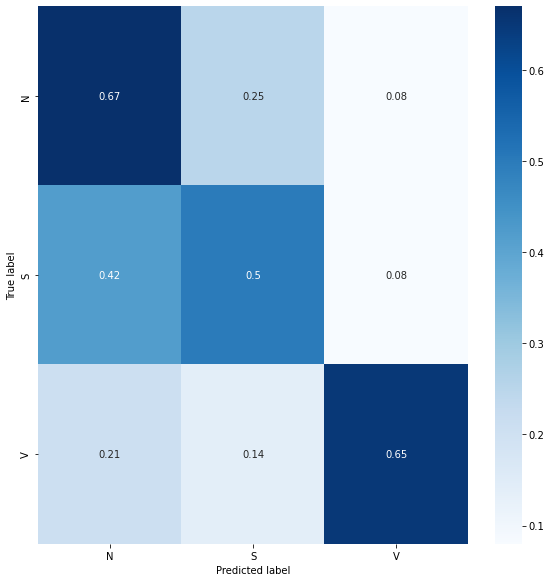

              precision    recall  f1-score   support

           N       0.56      0.67      0.61      2148
           S       0.56      0.50      0.53      1910
           V       0.76      0.65      0.70      1610

    accuracy                           0.61      5668
   macro avg       0.63      0.61      0.61      5668
weighted avg       0.62      0.61      0.61      5668



In [39]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

y_train_classes=np.argmax(y_train, axis=1)
# fit the model on the whole dataset
model.fit(x_train, y_train_classes)

# predict the class label
pred = model.predict(x_valid)

#y_val_classes=np.argmax(y_valid, axis=1)
y_val_classes=np.argmax(y_valid, axis=1)

plot_confusion_matrix(y_val_classes, pred)
                        
# Display classification results
print(classification_report(y_val_classes, pred, target_names=['N', 'S', 'V']))